In [1]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

# let's keep our keras backend tensorflow quiet
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
# for testing on CPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

# keras imports for the dataset and building our neural network
import keras
from keras.datasets import mnist
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
import tensorflow as tf
import pdb
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


Text(0.5,1,'Pixel Value Distribution')

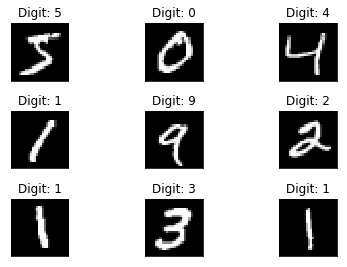

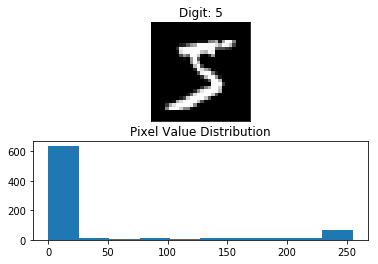

In [2]:
fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(X_train[i], cmap='gray', interpolation='none')
  plt.title("Digit: {}".format(y_train[i]))
  plt.xticks([])
  plt.yticks([])
    
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(X_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])
plt.subplot(2,1,2)
plt.hist(X_train[0].reshape(784))
plt.title("Pixel Value Distribution")

In [3]:
# let's print the shape before we reshape and normalize
print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

# building the input vector from the 28x28 pixels
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalizing the data to help with the training
X_train /= 255
X_test /= 255

# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Test matrix shape", X_test.shape)

('X_train shape', (60000, 28, 28))
('y_train shape', (60000,))
('X_test shape', (10000, 28, 28))
('y_test shape', (10000,))
('Train matrix shape', (60000, 784))
('Test matrix shape', (10000, 784))


In [4]:
print(np.unique(y_train, return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))


In [5]:
# one-hot encoding using keras' numpy-related utilities
n_classes = 10
print("Shape before one-hot encoding: ", y_train.shape)
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", Y_train.shape)

('Shape before one-hot encoding: ', (60000,))
('Shape after one-hot encoding: ', (60000, 10))


In [6]:
# building a linear stack of layers with the sequential model

#machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
#model.add(Dropout(0.2))

model.add(Dense(256))
model.add(Activation('relu'))
#model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.batches = []
        self.weight_save = []
        self.model_weights = model.get_weights()
        self.weight_masks = []
        for i in range(len(self.model_weights)):
            if i%2 == 0:
                self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                self.weight_masks.append(self.random_mask)
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights)       

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.batches.append(batch)
        self.model_weights = model.get_weights()
        for i in range(len(self.model_weights)):
            if i %2 == 0:
                self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
        model.set_weights(self.model_weights)
        self.weight_save.append(model.get_weights) 
       
                
l_history=LossHistory()
history = model.fit(X_train, Y_train,
          batch_size=128, epochs=10, verbose=1,
          validation_data=(X_test, Y_test), callbacks = [es, l_history])

# saving the model
model_name = 'keras_mnist.h5'
model.save(model_name)
print('Saved trained model %s ' % model_name)



Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 10s 169us/step - loss: 1.2153 - acc: 0.6777 - val_loss: 0.4033 - val_acc: 0.8959
Epoch 2/10
60000/60000 [==============================] - 10s 172us/step - loss: 0.3553 - acc: 0.8983 - val_loss: 0.3023 - val_acc: 0.9146
Epoch 3/10
60000/60000 [==============================] - 11s 177us/step - loss: 0.2963 - acc: 0.9140 - val_loss: 0.2700 - val_acc: 0.9217
Epoch 4/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.2670 - acc: 0.9225 - val_loss: 0.2468 - val_acc: 0.9270
Epoch 5/10
60000/60000 [==============================] - 11s 178us/step - loss: 0.2456 - acc: 0.9287 - val_loss: 0.2310 - val_acc: 0.9296
Epoch 6/10
60000/60000 [==============================] - 11s 176us/step - loss: 0.2274 - acc: 0.9341 - val_loss: 0.2165 - val_acc: 0.9345
Epoch 7/10
60000/60000 [==============================] - 11s 179us/step - loss: 0.2125 - acc: 0.9390 - val_loss: 0.

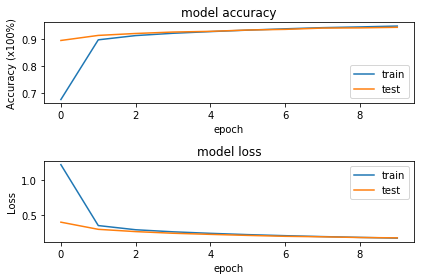

In [7]:
# plotting the metrics
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy (x100%)')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()


In [8]:
#from __future__ import division
for i in range(len(l_history.weight_masks)):
    print((np.count_nonzero(l_history.weight_masks[i])+0.0)/l_history.weight_masks[i].size)
    
print("---------------------------------------------------------------")    
for i in range(len(model.get_weights())):
    if i%2==0:
        print((np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)

0.0317357900191
0.0305786132812
0.0328125
---------------------------------------------------------------
0.0317357900191
0.0305786132812
0.0328125


In [9]:
mnist_model = load_model(model_name)
loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)

print("Test Loss {}.".format(loss_and_metrics[0]))
print("Test Accuracy {}%".format(loss_and_metrics[1]*100))

Test Loss 0.181735391863.
Test Accuracy 94.45%


(9445, ' classified correctly')
(555, ' classified incorrectly')


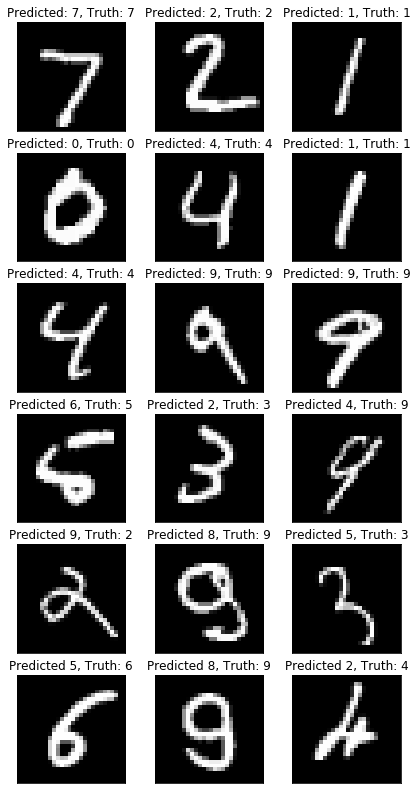

In [10]:
# load the model and create predictions on the test set
mnist_model = load_model(model_name)
predicted_classes = mnist_model.predict_classes(X_test)

# see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == y_test)[0]
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

# adapt figure size to accomodate 18 subplots
plt.rcParams['figure.figsize'] = (7,14)

figure_evaluation = plt.figure()

# plot 9 correct predictions
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(6,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.xticks([])
    plt.yticks([])

# plot 9 incorrect predictions
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(6,3,i+10)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.xticks([])
    plt.yticks([])

In [11]:
#Sweeping the sparsity and measuring the model accuracy

model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))                            
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

model_losses = []
model_accs = []
layerwise_sparsity = []
model_sparsity = []
for sparsity in range(5):
    print('Model training for sparsity # {0}'.format(sparsity+1))
    class LossHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.losses = []
            self.batches = []
            self.weight_save = []
            self.model_weights = model.get_weights()
            self.weight_masks = []
            for i in range(len(self.model_weights)):
                if i%2 == 0:
                    self.random_mask = np.logical_and(np.random.randint(0,2,self.model_weights[i].shape), np.random.randint(0,2,self.model_weights[i].shape))
                    for j in range(sparsity):
                        self.random_mask = np.logical_and(self.random_mask, np.random.randint(0,2,self.model_weights[i].shape))
                    self.weight_masks.append(self.random_mask)
            for i in range(len(self.model_weights)):
                if i == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights)       

        def on_batch_end(self, batch, logs={}):
            self.losses.append(logs.get('loss'))
            self.batches.append(batch)
            self.model_weights = model.get_weights()
            for i in range(len(self.model_weights)):
                if i %2 == 0:
                    self.model_weights[i] = np.multiply(self.model_weights[i], self.weight_masks[i/2])
            model.set_weights(self.model_weights)
            self.weight_save.append(model.get_weights) 

    l_history=LossHistory()
    history = model.fit(X_train, Y_train,
              batch_size=128, epochs=10, verbose=0,
              validation_data=(X_test, Y_test), callbacks = [es, l_history])

    loss_and_metrics = model.evaluate(X_test, Y_test, verbose=2)
    model_losses.append(loss_and_metrics[0])
    model_accs.append(loss_and_metrics[1])
    for i in range(len(model.get_weights())):
        if i%2==0:
            layerwise_sparsity.append(1 - (np.count_nonzero(model.get_weights()[i])+0.0)/model.get_weights()[i].size)
    model_sparsity.append(np.mean(layerwise_sparsity))


Model training for sparsity # 1
Model training for sparsity # 2
Model training for sparsity # 3
Model training for sparsity # 4
Model training for sparsity # 5


In [12]:
print(model_sparsity,model_accs,model_losses)

([0.7510646690316752, 0.8149491705862033, 0.8576016795878508, 0.8869422185988652, 0.9072128482740751], [0.9804, 0.9765, 0.9636, 0.9406, 0.843], [0.06752426255718455, 0.07018882004166953, 0.11917473636940122, 0.2006125691846013, 0.5199660141468048])


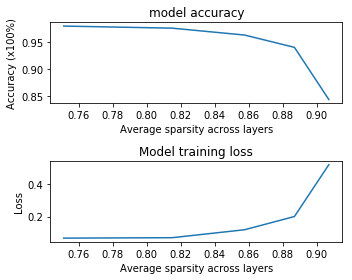

In [17]:
# plotting the metrics
fig = plt.figure(figsize = (5,4))
plt.subplot(2,1,1)
plt.plot(model_sparsity, model_accs)
plt.title('model accuracy')
plt.ylabel('Accuracy (x100%)')
plt.xlabel('Average sparsity across layers')

plt.subplot(2,1,2)
plt.plot(model_sparsity, model_losses)
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Average sparsity across layers')

plt.tight_layout()